<a href="https://colab.research.google.com/github/adasegroup/ML2023_seminars/blob/master/seminar8/Multiclass_Imbalanced_solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced classification: Imbalanced and Multi-class cases

In this seminar we will learn how to perform classification in case of multiple balanced or imbalanced classes.

The dataset, which we will use for this tutorial, is the smaller version [Stanford Dogs Dataset](http://vision.stanford.edu/aditya86/ImageNetDogs/). The initial dataset consists from images of 120 breeds of dogs. In our case we are going to use just 4 classes out of those 120.

![dogs_pic](https://dog.ceo/img/dog-api-fb.jpg)

#### The plan of the seminar:
* A small introduction to Stanford Dogs Dataset
* Producing the features of the images using the pretrained neural network (we will consider it as a black box)
* Multi-class classification methods: One-vs-One and One-vs-Rest
* Imbalanced dataset - why is it a problem?
* Imbalanced classification methods: Over and Under-Sampling, SMOTE

Let us start with some library imports.

In [ ]:
!pip install -U imbalanced-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.7/257.7 kB 2.0 MB/s eta 0:00:00
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.10.1
    Uninstalling imbalanced-learn-0.10.1:
      Successfully uninstalled imbalanced-learn-0.10.1


In [ ]:
!wget https://github.com/adasegroup/ML2023_seminars/raw/main/seminar8/data/dog_breeds.zip

--2024-02-12 10:47:11--  https://github.com/adasegroup/ML2023_seminars/raw/main/seminar8/data/dog_breeds.zip
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/adasegroup/ML2023_seminars/main/seminar8/data/dog_breeds.zip [following]
--2024-02-12 10:47:11--  https://raw.githubusercontent.com/adasegroup/ML2023_seminars/main/seminar8/data/dog_breeds.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23897097 (23M) [application/zip]
Saving to: ‘dog_breeds.zip’

dog_breeds.zip      100%[===================>]  22.79M   121MB/s    in 0.2s    

2024-02-12 10:47:11 (121 MB/s) - ‘dog_breeds.zip’ saved [2389

In [ ]:
!unzip -oqd "./" "dog_breeds.zip"

In [ ]:
!ls .

dog_breeds.zip	n02090622-borzoi	    n02102318-cocker_spaniel  sample_data
__MACOSX	n02099601-golden_retriever  n02107142-Doberman


In [ ]:
!rm -rf ./__MACOSX ./sample_data .config ./dog_breeds.zip

In [ ]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import urllib
%matplotlib inline
from PIL import Image
from torchvision import transforms
import os
import sklearn
import os.path
from tqdm.autonotebook import tqdm

In [ ]:
paths_doggies = [i for i in os.listdir('./') if '.DS_' not in i
                 and '.ipynb' not in i]

In [ ]:
#if you load your data from the local directory
#################################
#path_doggies ="dog_breeds/small"
#paths_doggies = [path_doggies +'/'+ i for i in os.listdir(path_doggies) if '.DS_' not in i]
#################################

<br>

Now let us have a look at the data

In [ ]:
def img_show(img, ax, title = None):
    """
    Plots the image on the particular axis

    Parameters
    ----------
    img: Image, image to plot.
    axis: matplotlib axis to plot on.
    title: string, the title of the image

    """
    ax.imshow(img)
    ax.axis('off')
    if title:
        ax.set_title(title)

In [ ]:
#images for plotting
img_names = {}
for num, i in enumerate(paths_doggies[:4]):
    img_names.update({i.split('-')[-1]:paths_doggies[num]+'/'+os.listdir(i)[0]})


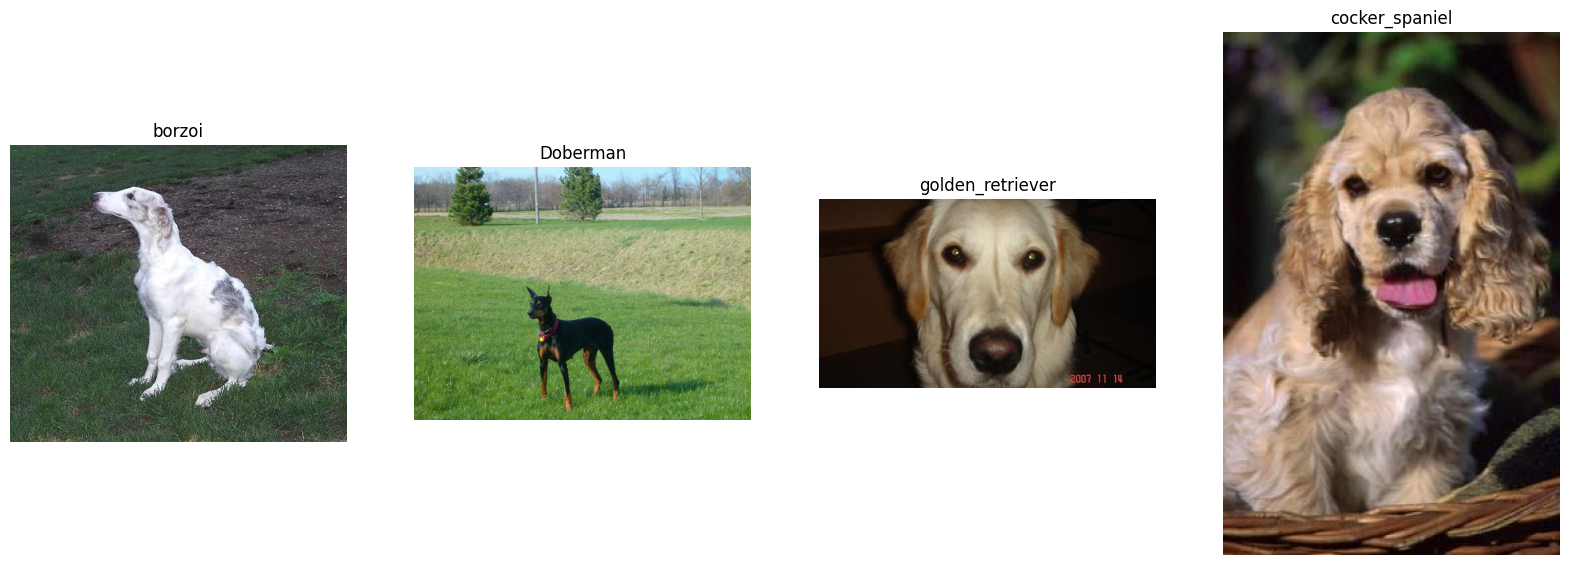

In [ ]:
#plot the images from img_names
fig, ax = plt.subplots(1,4, figsize=(20,10))
k = 0
for i, key in enumerate(img_names.keys()):
    img_show(Image.open(img_names[key]), ax[i], title = key)
plt.show()

In order to make working with the data much easier, we are going to create a class, that will store the ```image_to_features``` model, the ```data_list```, containing all the vectors of features of the image samples and the ```data_path```.

In [ ]:
class DogBreedDataset:
    def __init__(self, data_path, feature_generator, num_samples=None):
        """
        A wrapper class for Stanford Dog Breeds dataset.

        Parameters
        ----------
        data_path: string, the path to the dataset.
        feature_generator: torch.nn.Module, the model, that receives the torch.tensor of the preprocessed image
                           as the input and produces the tensor of features as the output.
        num_samples: integer, the number of samples in each class to load, default: None.
        """
        self.data_path = data_path
        self.model = feature_generator
        self.num_samples = num_samples
        self.data_list = []

    def preprocess_image(self, image):
        """
        Opens and preprocesses an Image according to the requirements mentioned at https://pytorch.org/hub/pytorch_vision_vgg/

        Parameters
        ----------
        path: the path to the image.
        img_name: the name of the image file.

        Returns
        -------
        input_tensor: the tensor of the preprocessed image.
        input_batch: input_tensor with an extra dim, representing a batch
        """

        preprocess = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])
        input_tensor = preprocess(image)
        input_batch = input_tensor.unsqueeze(0)
        return input_batch

    def load_dataset(self):
        """
        Loads and preprocesses the images from the dataset

        Parameters
        ----------
        path: the path to the image.
        img_name: the name of the image file.

        Returns
        -------
        data_list: the list of vectors of features of dogs' images
        """
        data_list = []
        for path in tqdm(self.data_path):
            counter = 0
            for filename in tqdm(os.listdir(path)):
                counter += 1
                # input
                with open(os.path.join(path, filename), 'rb') as file:
                    batch = self.preprocess_image(Image.open(file))

                with torch.no_grad():
                    features = self.model(batch).flatten().cpu().numpy()

                # label
                _, label = path.split('-', 1)
                data_list.append((features, label))

                if counter >= self.num_samples:
                    break

        return data_list

The model that we are going to use to get our features from these raw images is the Neural Network called **VGG-11** (you are going to learn about these types of NN models later in this course).

Lucky for us, [```PyTorch```](https://pytorch.org) library stores some of the most popular [pretrained Neural Networks](https://pytorch.org/hub/), so we don't have to design and train the VGG-11 NN from sctratch.

In [ ]:
# import ssl

# ssl._create_default_https_context = ssl._create_unverified_context

In [ ]:
#dowbload the VGG11 model from pytorch hub
model = torch.hub.load('pytorch/vision:v0.11.0', 'vgg11', pretrained=True)

Downloading: "https://github.com/pytorch/vision/zipball/v0.11.0" to /root/.cache/torch/hub/v0.11.0.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg11-8a719046.pth" to /root/.cache/torch/hub/checkpoints/vgg11-8a719046.pth
100%|██████████| 507M/507M [00:06<00:00, 84.8MB/s]


![](https://neurohive.io/wp-content/uploads/2018/11/vgg16-1-e1542731207177.png)

However, we do not need the whole network for producing the images' features - we will take only the part of it, just before the first __fully connected__ layer.

In [ ]:
#take only the "head" that outputs the images' features
image_to_feats = model.features

In [ ]:
image_to_feats.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU(inplace=True)
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace=True)
  (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU(inplace=True)
  (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (12): ReLU(inplace=True)
  (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (14): ReLU(inplace=True)
  (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (16): Conv2d(512, 512, kernel_size=(3, 3), stride=

Let's have a look at our data:

Let us download, preprocess and store the features of the images in a pandas dataframe

In [ ]:
dataset_class = DogBreedDataset(paths_doggies, image_to_feats, num_samples = 150)

In [ ]:
datalist = dataset_class.load_dataset()

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/151 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/159 [00:00<?, ?it/s]

Let's create a pandas dataframe with all the features and labels.

In [ ]:
#derive the list of labels from the paths_doggies list

#take the data_list and after each list of features add the data label

#create a list of column names

#create a df_doggies dataframe

In [ ]:
features, label = datalist[0]

In [ ]:
columns = [f"feat_{i+1}" for i in range(len(features))]
df_doggies = pd.DataFrame(
    [feat for feat, lab in datalist],
    columns=columns)

df_doggies["y"] = [lab for feat, lab in datalist]

In [ ]:
df_doggies.shape

(600, 25089)

In [ ]:
df_doggies.head()

,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,...,feat_25080,feat_25081,feat_25082,feat_25083,feat_25084,feat_25085,feat_25086,feat_25087,feat_25088,y
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.146679,0.0,0.0,0.0,0.0,0.0,borzoi
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.126138,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,borzoi
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,borzoi
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,borzoi
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,borzoi


Turn the labels to Categorical type and create the dictionary, in case we would like to recover the original labels

In [ ]:
df_doggies.y = pd.Categorical(df_doggies.y)

In [ ]:
label_map = dict(enumerate(df_doggies.y.cat.categories) )

In [ ]:
label_map

{0: 'Doberman', 1: 'borzoi', 2: 'cocker_spaniel', 3: 'golden_retriever'}

In [ ]:
df_doggies.y = df_doggies.y.cat.codes

## Plotting the data using dimensinonality reduction techniques

DataPlotter is another blackbox that we are going to use for representing our features in a more convenient way for plotting (later in the course you will learn about PCA and TSNE).


Let's plot our data!

In [ ]:
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.decomposition import PCA

class DataPlotter:
    def __init__(self, data, dim_red = 'pca', X=None, y=None):
        """
        A wrapper class for dimensionality reduction and plotting.

        Parameters
        ----------
        data_path: dataframe, the dataset.
        dim_red: string, the dimensionality reduction technique to use, either 'tsne' or 'pca'.
        """
        self.data = data
        self.dim_red = dim_red
        self.X = X
        self.y = y
        if X is None:
            self.X = self.data.loc[:, self.data.columns!='y']
        if y is None:
            self.y = self.data.y.astype(int)

    def shuffle_data(self):
        """
        Randomly shuffling the data.
        """
        self.X = self.X.sample(frac=1).reset_index(drop=True)
        self.y = self.y.sample(frac=1).reset_index(drop=True)

    def reduce_dimension(self):
        """
        Reduce the current dimension of the feature data to 2 dimensions using either pca or tsne.
        """
        if self.dim_red =='tsne':
            self.X_embedded = TSNE(n_components=2, perplexity=30.0).fit_transform(self.X)
        elif self.dim_red == 'pca':
            self.X_embedded = PCA(n_components=2).fit_transform(self.X)

    def plot_data(self):
        plt.figure(figsize=(20,10))
        sns.scatterplot(x=self.X_embedded[:,0], y=self.X_embedded[:,1], hue = self.y, palette="rainbow", s=100,
                        legend = "full")

In [ ]:
data_pltr = DataPlotter(df_doggies, dim_red = 'pca')

In [ ]:
data_pltr.reduce_dimension()

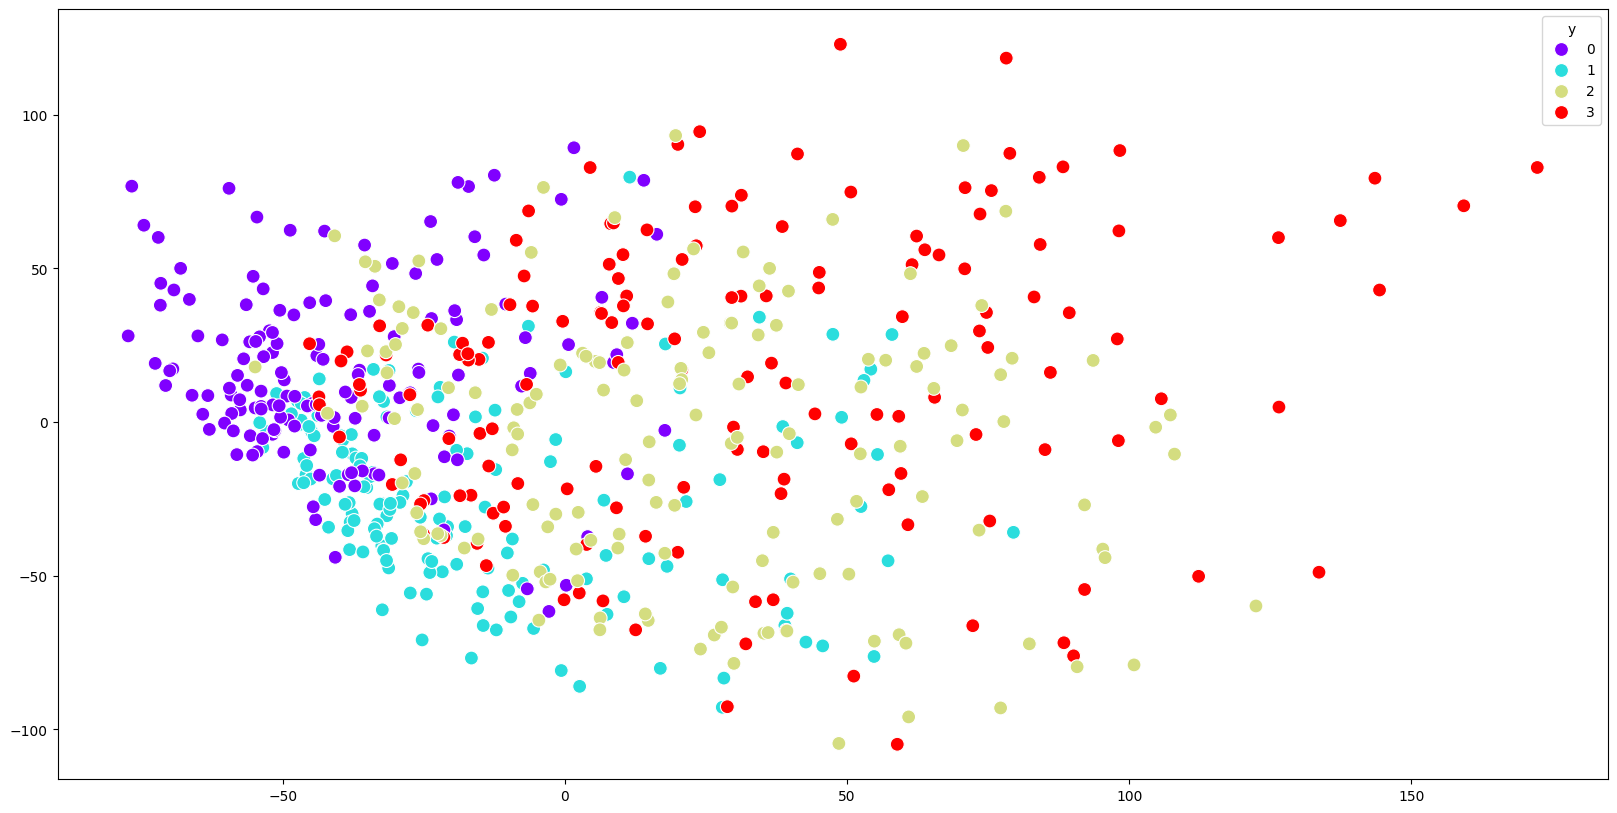

In [ ]:
data_pltr.plot_data()

## Multi-class classification

Finally, let's try some multi-clall classification methods.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.base import clone

Train-test split

In [ ]:
y = df_doggies.y.astype(int)
X = df_doggies.loc[:, df_doggies.columns!='y']

split = train_test_split(X, y, test_size=0.5,
                         random_state=42, stratify=y)
train_X, test_X, train_y, test_y = split

Most of the binary classification methods that you have already discussed in the previous seminars, unfortuntelly, only allow to distinguish one class from the other. However, in our case, we want to classify several dog breeds, so how can we do that?

One way to this problem is using **One-vs-All** approach:
![](https://miro.medium.com/max/1574/1*7sz-bpA4r_xSqAG3IJx-7w.jpeg)

In [ ]:
from sklearn.svm import LinearSVC
# from sklearn.linear_model import LogisticRegression

model_SVC = LinearSVC(random_state=0)
# model_LogReg = LogisticRegression(random_state=0)

In [ ]:
from sklearn.multiclass import OneVsRestClassifier

ovr_classifier = OneVsRestClassifier(clone(model_SVC), n_jobs=-1)
ovr_classifier.fit(train_X, train_y)

OneVsRestClassifier(estimator=LinearSVC(random_state=0), n_jobs=-1)

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
predict_y = ovr_classifier.predict(test_X)

cmatrix = confusion_matrix(test_y, predict_y)
pd.DataFrame(cmatrix)

,0,1,2,3
0,75,0,0,0
1,1,70,3,1
2,1,3,61,10
3,1,4,3,67


rows -- fact
columns -- predict

In [ ]:
print("Accuracy %.3f%%" % (100 * ovr_classifier.score(test_X, test_y)))


Accuracy 91.000%


### One-vs-One approach to multi-class classification

![](https://ars.els-cdn.com/content/image/1-s2.0-S0950705116301459-gr1.jpg)

In [ ]:
from sklearn.multiclass import OneVsOneClassifier

ovo_classifier = OneVsOneClassifier(clone(model_SVC))

ovo_classifier.fit(train_X, train_y)

OneVsOneClassifier(estimator=LinearSVC(random_state=0))

In [ ]:
predict_y = ovo_classifier.predict(test_X)

In [ ]:
print("Accuracy %.3f%%" % (100 * ovo_classifier.score(test_X, test_y)))

Accuracy 90.000%


In [ ]:
pd.DataFrame(confusion_matrix(test_y, predict_y))

,0,1,2,3
0,74,0,1,0
1,1,71,2,1
2,1,3,58,13
3,0,4,4,67


## Imbalanced data

Data imbalance is a very common problem for many machine learning problems. Consider volcano erruption, or plane crush prediction - there is an abundance of negative examples, when the event does not happen and very little recorded cases of the events, the occurence of which we want to predict.

This is where various methods of class balancing is going to help.

In [ ]:
# df_doggies_subset = df_doggies1.loc[df_doggies1.y.isin([0,1,2,3])]

In [ ]:
X_sub, y_sub = df_doggies.loc[:, df_doggies.columns!='y'], df_doggies.y.astype(int)

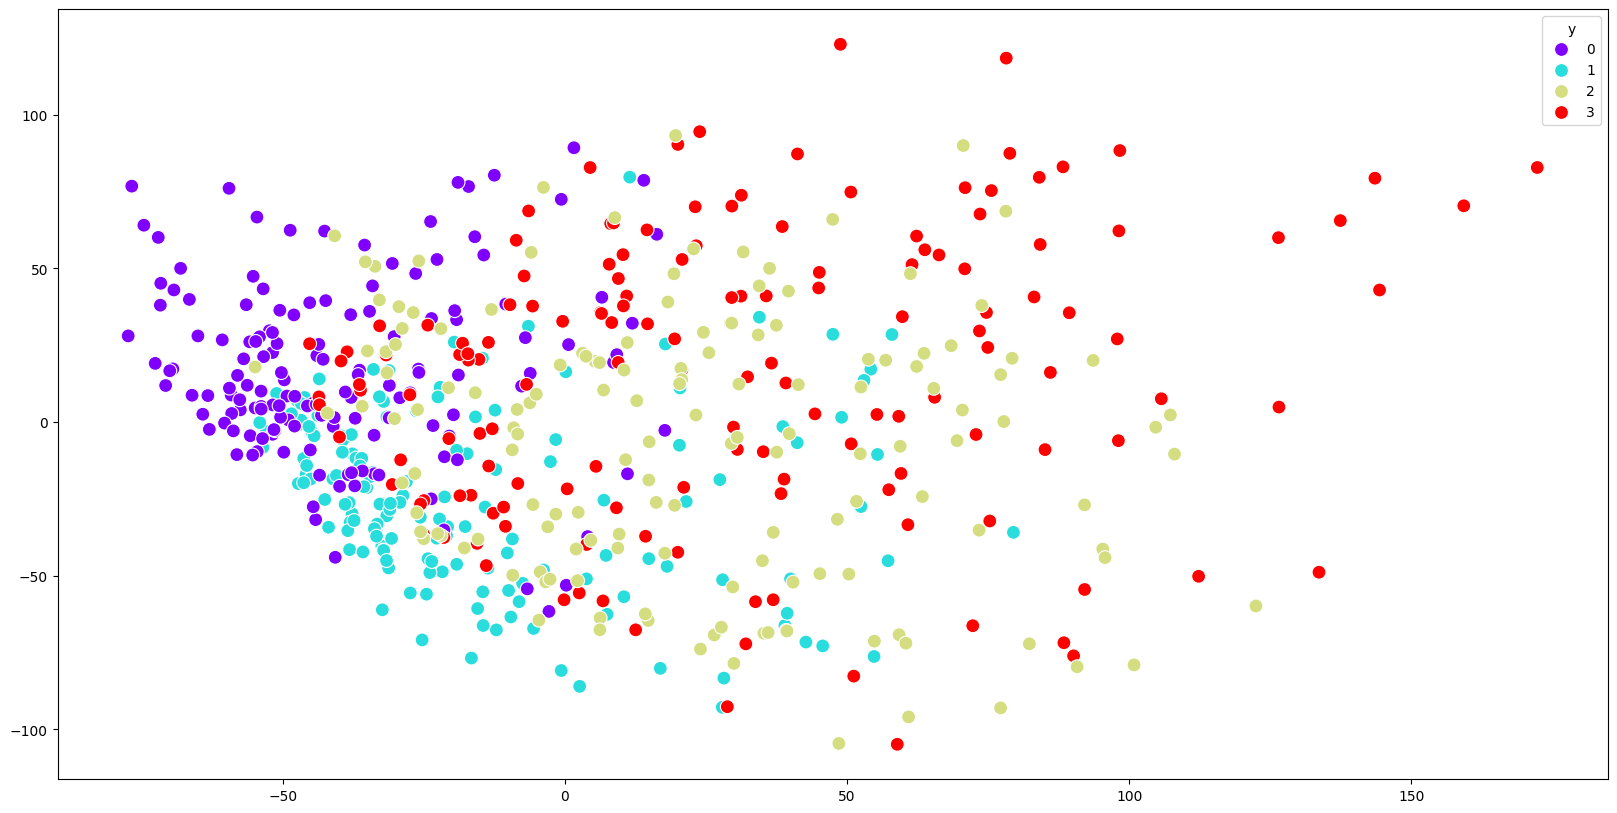

In [ ]:
data_pltr = DataPlotter(df_doggies, dim_red = 'pca')
data_pltr.reduce_dimension()
data_pltr.plot_data()

In [ ]:
from collections import Counter
print('Distribution before imbalancing: {}'.format(Counter(y_sub)))

Distribution before imbalancing: Counter({1: 150, 0: 150, 3: 150, 2: 150})


In [ ]:
from imblearn.datasets import make_imbalance
X_res, y_res = make_imbalance(
    X_sub, y_sub, sampling_strategy={0: 150, 1: 150, 2: 30, 3: 150},
    random_state=1)


In [ ]:
print('Distribution after imbalancing: {}'.format(Counter(y_res)))

Distribution after imbalancing: Counter({0: 150, 1: 150, 3: 150, 2: 30})


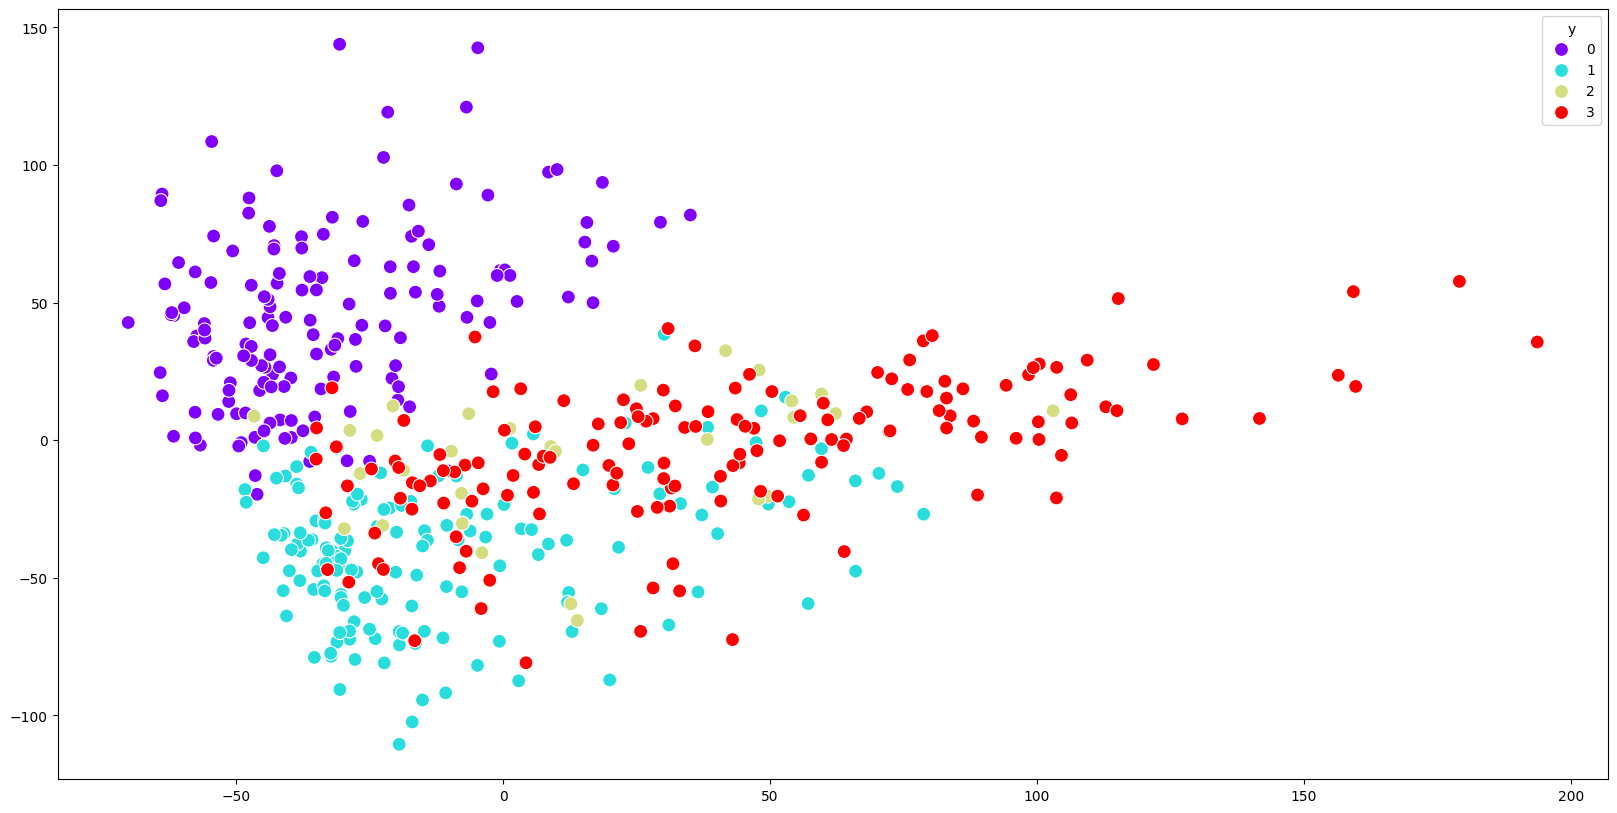

In [ ]:
data_pltr = DataPlotter(df_doggies, dim_red = 'pca', X = X_res, y = y_res)
data_pltr.reduce_dimension()
data_pltr.plot_data()

In [ ]:
split = train_test_split(X_res, y_res, test_size=0.3,
                         random_state=42, stratify=y_res)
train_X, test_X, train_y, test_y = split

In [ ]:
from sklearn.linear_model import RidgeClassifier
model_SVC = LinearSVC(random_state=50)
#model_SVC = RidgeClassifier(random_state=0)
ovr_classifier = OneVsRestClassifier(clone(model_SVC), n_jobs=-1)
ovr_classifier.fit(train_X, train_y)

OneVsRestClassifier(estimator=LinearSVC(random_state=50), n_jobs=-1)

In [ ]:
predictions = ovr_classifier.predict(test_X)
#predictions = model_SVC.predict(test_X[test_y==0])

In [ ]:
from imblearn.metrics import classification_report_imbalanced

In [ ]:
print("Accuracy %.3f%%" % (100 * ovr_classifier.score(test_X, test_y)))

Accuracy 93.056%


In [ ]:
print(classification_report_imbalanced(test_y, predictions))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.96      1.00      0.98      0.98      0.99      0.98        45
          1       0.96      0.98      0.98      0.97      0.98      0.96        45
          2       1.00      0.22      1.00      0.36      0.47      0.20         9
          3       0.88      0.96      0.94      0.91      0.95      0.90        45

avg / total       0.93      0.93      0.97      0.92      0.94      0.90       144



## Techniques to try, when dealing with the imabalanced dataset:
* Under/Over Sampling
* Synthetic minority over-sampling technique and its variants (ADASYN, BorderlineSMOTE, etc)

In [ ]:
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [ ]:
balancer = RandomUnderSampler()

In [ ]:
balanced_train_x, balanced_train_y = balancer.fit_resample(train_X, train_y)

In [ ]:
print('Distribution before balancing: {}'.format(Counter(train_y)))

Distribution before balancing: Counter({1: 105, 0: 105, 3: 105, 2: 21})


In [ ]:
print('Distribution after balancing: {}'.format(Counter(balanced_train_y)))

Distribution after balancing: Counter({0: 21, 1: 21, 2: 21, 3: 21})


In [ ]:
model = LinearSVC(random_state=50, )
ovr_classifier = OneVsRestClassifier(clone(model), n_jobs=-1)
ovr_classifier.fit(balanced_train_x, balanced_train_y)

OneVsRestClassifier(estimator=LinearSVC(random_state=50), n_jobs=-1)

In [ ]:
print("Accuracy %.3f%%" % (100 * ovr_classifier.score(test_X, test_y)))

Accuracy 88.889%


In [ ]:
predictions = ovr_classifier.predict(test_X)
#predictions = model.predict(test_X[test_y==0])

In [ ]:
print(classification_report_imbalanced(test_y, predictions))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.93      0.96      0.97      0.95      0.96      0.93        45
          1       0.90      0.96      0.95      0.92      0.95      0.91        45
          2       0.60      0.67      0.97      0.63      0.80      0.63         9
          3       0.90      0.80      0.96      0.85      0.88      0.76        45

avg / total       0.89      0.89      0.96      0.89      0.92      0.85       144



In [ ]:
pd.DataFrame(confusion_matrix(test_y, predictions))

,0,1,2,3
0,43,1,0,1
1,0,43,0,2
2,1,1,6,1
3,2,3,4,36


In [ ]:
balancer = RandomOverSampler()

In [ ]:
balanced_train_x, balanced_train_y = balancer.fit_resample(train_X, train_y)

In [ ]:
print('Distribution after balancing: {}'.format(Counter(balanced_train_y)))

Distribution after balancing: Counter({1: 105, 0: 105, 3: 105, 2: 105})


In [ ]:
model = LinearSVC(random_state=50)
ovr_classifier = OneVsRestClassifier(clone(model), n_jobs=-1)
ovr_classifier.fit(balanced_train_x, balanced_train_y)

OneVsRestClassifier(estimator=LinearSVC(random_state=50), n_jobs=-1)

In [ ]:
print("Accuracy %.3f%%" % (100 * ovr_classifier.score(test_X, test_y)))

Accuracy 93.056%


In [ ]:
predictions = ovr_classifier.predict(test_X)

In [ ]:
pd.DataFrame(confusion_matrix(test_y, predictions))

,0,1,2,3
0,45,0,0,0
1,0,44,0,1
2,1,1,2,5
3,1,1,0,43


In [ ]:
print(classification_report_imbalanced(test_y, predictions))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.96      1.00      0.98      0.98      0.99      0.98        45
          1       0.96      0.98      0.98      0.97      0.98      0.96        45
          2       1.00      0.22      1.00      0.36      0.47      0.20         9
          3       0.88      0.96      0.94      0.91      0.95      0.90        45

avg / total       0.93      0.93      0.97      0.92      0.94      0.90       144



## SMOTE

<img src="https://ars.els-cdn.com/content/image/1-s2.0-S0950705119302898-gr1.jpg" alt="smote" width="600"/>

In [ ]:
rebalancer = SMOTE(sampling_strategy='not majority', k_neighbors=5, random_state = 1)

In [ ]:
under_balancer = RandomUnderSampler(sampling_strategy={0:20, 1: 30, 3:50}, random_state = 1)

In [ ]:
balanced_train_x, balanced_train_y = under_balancer.fit_resample(train_X, train_y)

In [ ]:
print('Distribution before balancing: {}'.format(Counter(balanced_train_y)))

Distribution before balancing: Counter({3: 50, 1: 30, 2: 21, 0: 20})


In [ ]:
model = LinearSVC(random_state=0)

ovr_classifier = OneVsRestClassifier(clone(model))
X_SMOTE, y_SMOTE = rebalancer.fit_resample(balanced_train_x, balanced_train_y)
print('Distribution after balancing: {}'.format(Counter(y_SMOTE)))
ovr_classifier = ovr_classifier.fit(X_SMOTE, y_SMOTE)

Distribution after balancing: Counter({0: 50, 1: 50, 2: 50, 3: 50})


In [ ]:
predict_y_balanced = ovr_classifier.predict(test_X)
pd.DataFrame(confusion_matrix(test_y, predict_y_balanced))

,0,1,2,3
0,42,1,0,2
1,0,43,0,2
2,1,0,5,3
3,1,1,1,42


In [ ]:
print("Accuracy %.3f%%" % (100 * ovr_classifier.score(test_X, test_y)))

Accuracy 91.667%


In [ ]:
print(classification_report_imbalanced(test_y, predict_y_balanced))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.95      0.93      0.98      0.94      0.96      0.91        45
          1       0.96      0.96      0.98      0.96      0.97      0.93        45
          2       0.83      0.56      0.99      0.67      0.74      0.53         9
          3       0.86      0.93      0.93      0.89      0.93      0.87        45

avg / total       0.92      0.92      0.96      0.91      0.94      0.88       144



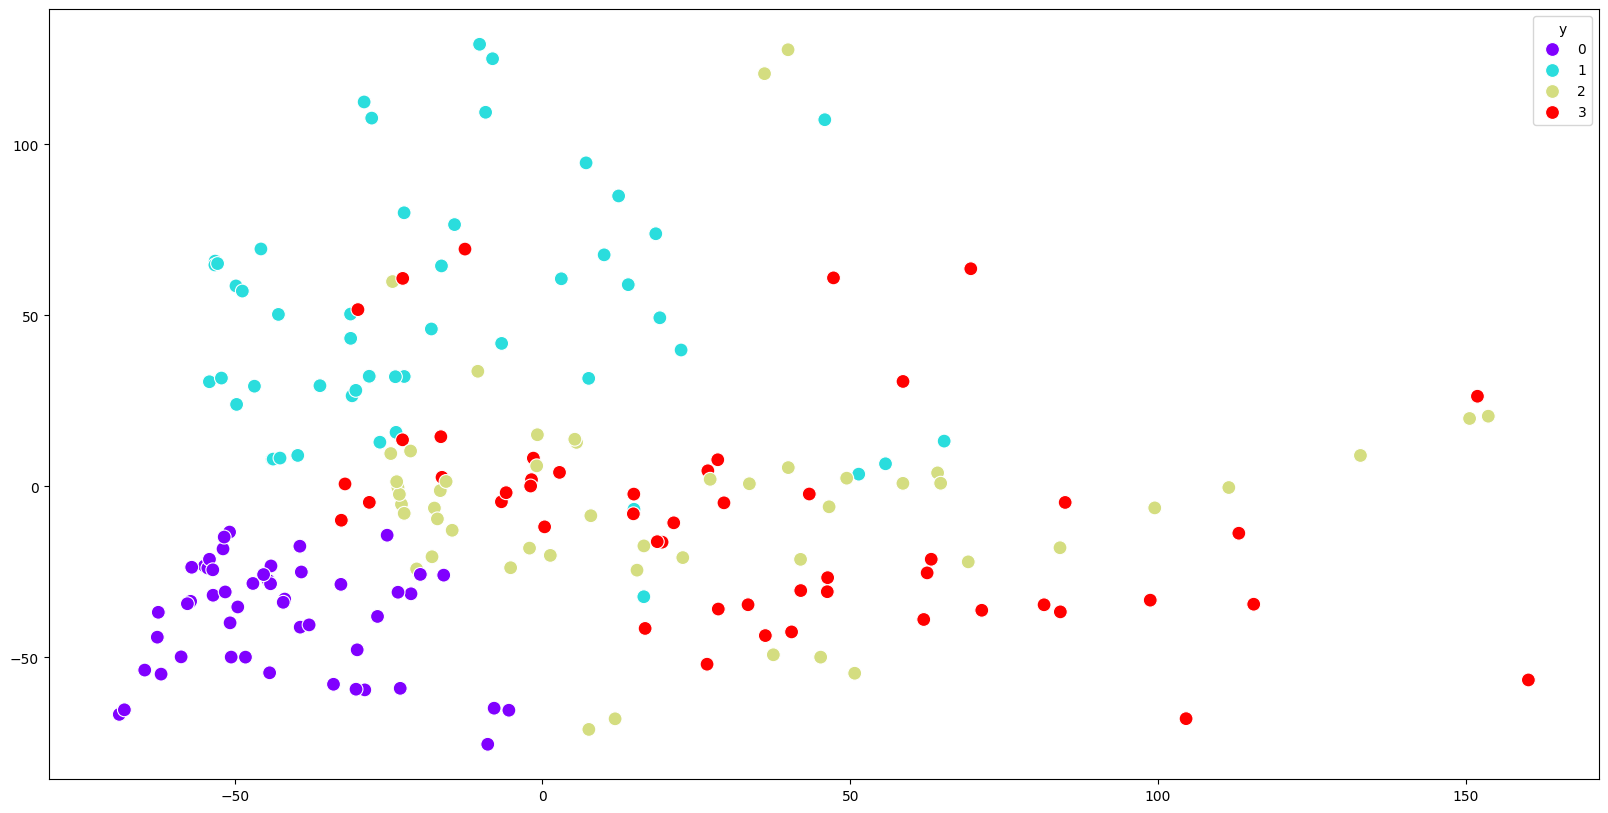

In [ ]:
data_pltr = DataPlotter(df_doggies, dim_red = 'pca', X = X_SMOTE, y = y_SMOTE)
data_pltr.reduce_dimension()
data_pltr.plot_data()

There are different variations of SMOTE method, such as ADASYN, BalancedSMOTE etc. Many of them are avaliable in [```imblearn```](https://imbalanced-learn.org/stable/) library.

**Try out those methods yourself, using the mentioned methods, plot and analyze the results.**

Distribution after balancing: Counter({0: 50, 1: 50, 2: 50, 3: 50})
                   pre       rec       spe        f1       geo       iba       sup

          0       0.95      0.93      0.98      0.94      0.96      0.91        45
          1       0.96      0.96      0.98      0.96      0.97      0.93        45
          2       0.83      0.56      0.99      0.67      0.74      0.53         9
          3       0.86      0.93      0.93      0.89      0.93      0.87        45

avg / total       0.92      0.92      0.96      0.91      0.94      0.88       144

Distribution after balancing: Counter({0: 57, 3: 50, 1: 48, 2: 47})
                   pre       rec       spe        f1       geo       iba       sup

          0       0.95      0.93      0.98      0.94      0.96      0.91        45
          1       0.96      0.96      0.98      0.96      0.97      0.93        45
          2       0.83      0.56      0.99      0.67      0.74      0.53         9
          3       0.86      0.

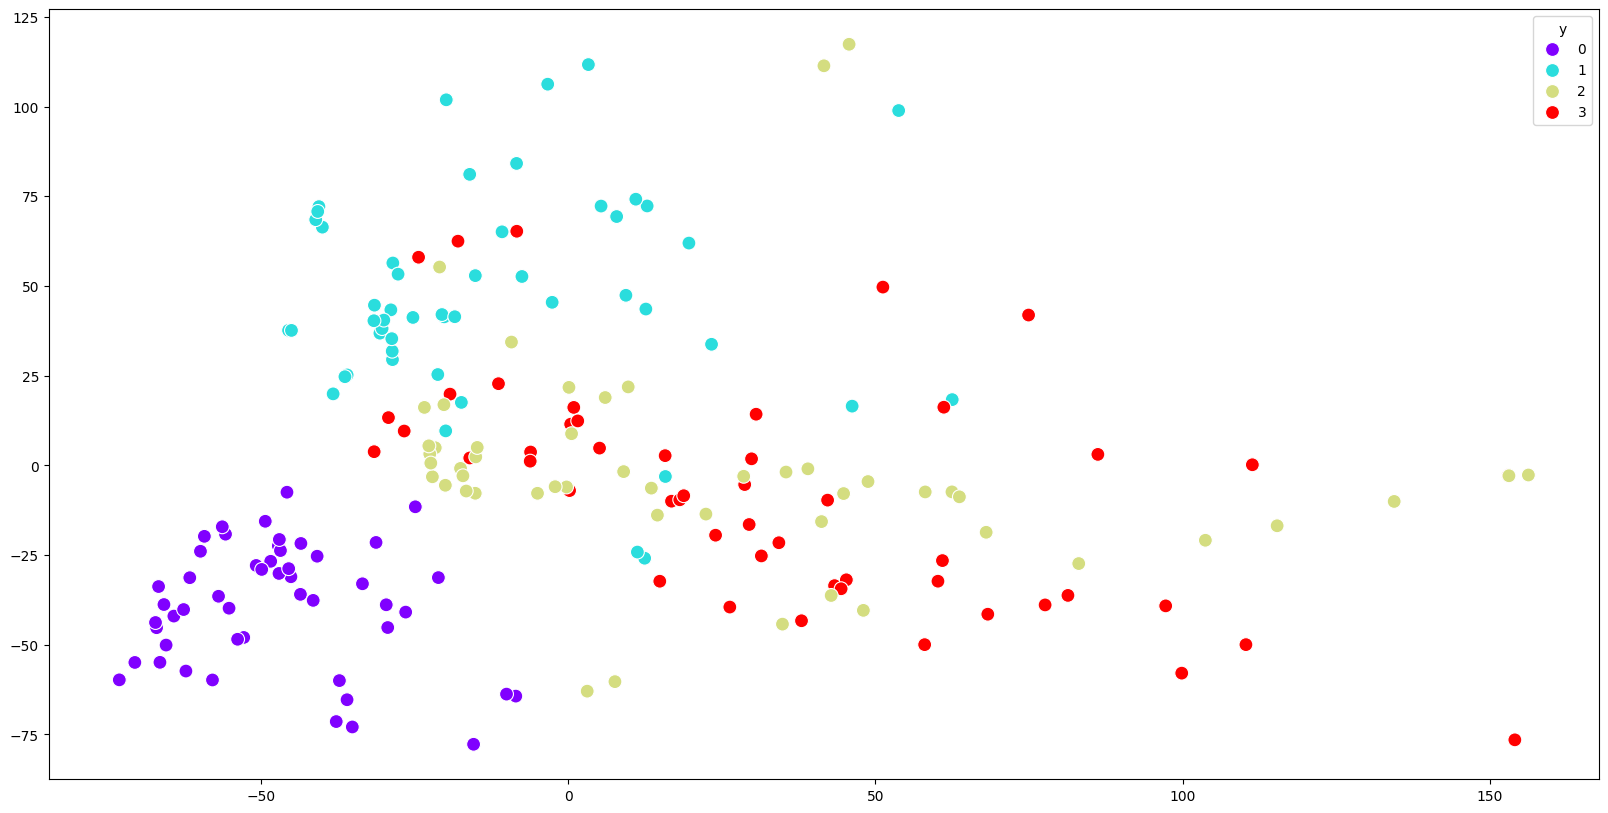

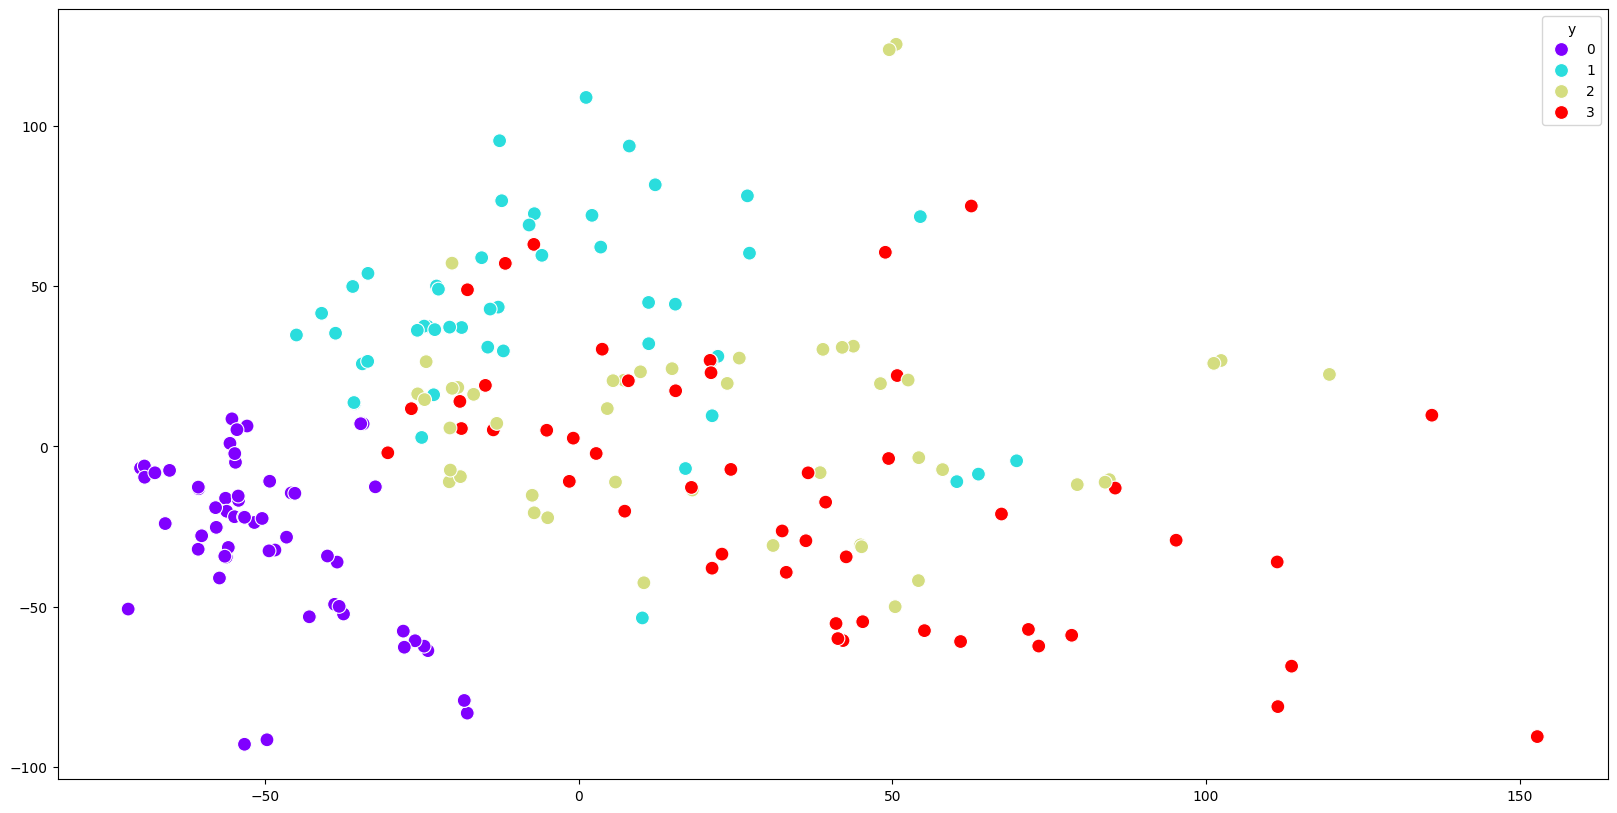

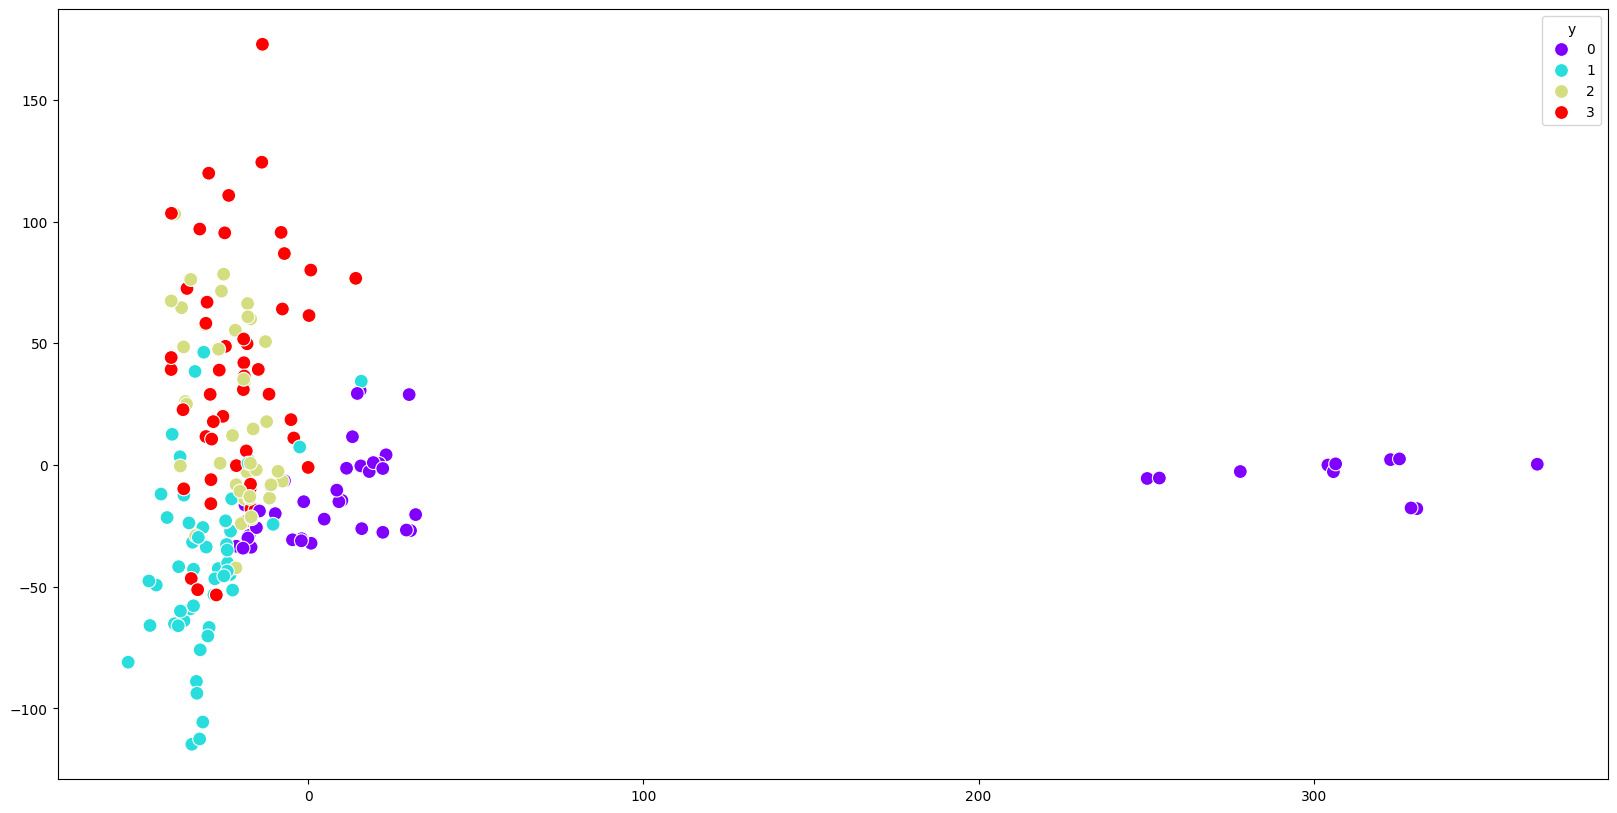

In [ ]:
from imblearn.over_sampling import BorderlineSMOTE, ADASYN, SVMSMOTE

rebalancer_list = [BorderlineSMOTE(random_state = 1),
                   ADASYN(n_neighbors = 3, random_state = 1),
                   SVMSMOTE(random_state = 1)]
model = LinearSVC(random_state=0)

for rebalancer in rebalancer_list:
    ovr_classifier = OneVsRestClassifier(clone(model))
    X_SMOTE, y_SMOTE = rebalancer.fit_resample(balanced_train_x, balanced_train_y)
    print('Distribution after balancing: {}'.format(Counter(y_SMOTE)))
    ovr_classifier = ovr_classifier.fit(X_SMOTE, y_SMOTE)
    predict_y_balanced = ovr_classifier.predict(test_X)
    print(classification_report_imbalanced(test_y, predict_y_balanced))
    data_pltr = DataPlotter(df_doggies, dim_red = 'pca', X = X_SMOTE, y = y_SMOTE)
    data_pltr.reduce_dimension()
    data_pltr.plot_data()